In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from torch.utils import data

In [12]:
iris = load_iris()
print(iris.keys())

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [13]:
dataset = iris['data']
dataset.size

600

In [14]:
dataset = np.asarray(dataset)
dataset

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [15]:
training_features = dataset[:, :-1]
target_features = dataset[:, -1]

In [16]:
splitdata = np.split(training_features, [120])
train_features = splitdata[0]
test_features = splitdata[1]

splitdata = np.split(target_features, [120])
train_target = splitdata[0]
test_target = splitdata[1]

train_missing = train_target.copy()
test_missing = test_target.copy()

In [17]:
REPLACE_COUNT = train_missing.size*0.25
NAN = 0

train_missing.flat[np.random.choice(train_missing.size, int(REPLACE_COUNT), replace=False)] =  NAN

# Using 0.2 because the test set is a 0.2 subset of the whole dataset
test_missing.flat[np.random.choice(test_missing.size, int(REPLACE_COUNT*0.2), replace=False)] = NAN 


In [18]:
train_features.shape

(120, 3)

In [19]:
x_train = torch.from_numpy(train_features)
x_train = x_train.view(1, 120, 3)

x_test = torch.from_numpy(test_features)
x_test = x_test.view(1, 30, 3)

y_train = torch.from_numpy(train_target)
y_train = y_train.view(1, 120, 1)

y_test = torch.from_numpy(test_target)
y_test = y_test.view(1, 30, 1)


print(x_train.shape)

torch.Size([1, 120, 3])


In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.enc1 = nn.Linear(in_features=3, out_features=2)
        self.enc2 = nn.Linear(in_features=2, out_features=1)

        self.dec1 = nn.Linear(in_features=1, out_features=1)

    
    def forward(self, x):
        x = F.leaky_relu(self.enc1(x))
        x = F.leaky_relu(self.enc2(x))
        x = self.dec1(x)
        return x


In [11]:
net = Autoencoder().double()
print(net)

Autoencoder(
  (enc1): Linear(in_features=3, out_features=2, bias=True)
  (enc2): Linear(in_features=2, out_features=1, bias=True)
  (dec1): Linear(in_features=1, out_features=1, bias=True)
)


In [7]:
NUM_EPOCHS = 3000
LEARNING_RATE = 0.001
BATCH_SIZE = 120

In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
print(len(x_train))

1


In [9]:
def train(net):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data, target in zip(x_train, y_train):
            optimizer.zero_grad()
            outputs = net(data.double())
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if epoch == NUM_EPOCHS-1:
                for i in range(len(data)):
                    print("Input: ", data[i])
                    print("Target: ", target[i])
                    print("Outputs: ", outputs[i])
        loss = running_loss / len(x_train)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'
            .format(epoch+1, NUM_EPOCHS, loss))
    return train_loss

def test(net):

    net.eval()

    with torch.no_grad():
        test_loss = []
        running_loss = 0.0
        for data, target in zip(x_test, y_test):
            outputs = net(data.double())
            loss = criterion(outputs, target)
            running_loss += loss.item()
            for i in range(len(data)):
                print("Input: ", data[i])
                print("Target: ", target[i])
                print("Outputs: ", outputs[i])
        loss = running_loss / len(x_test)
        test_loss.append(loss)
        print('Test Loss: {:.3f}'.format(loss))

        return test_loss
        

In [15]:
train_loss1 = train(net)


.2608], dtype=torch.float64, grad_fn=<SelectBackward>)
Input:  tensor([4.8000, 3.4000, 1.6000], dtype=torch.float64)
Target:  tensor([0.2000], dtype=torch.float64)
Outputs:  tensor([0.3201], dtype=torch.float64, grad_fn=<SelectBackward>)
Input:  tensor([4.8000, 3.0000, 1.4000], dtype=torch.float64)
Target:  tensor([0.1000], dtype=torch.float64)
Outputs:  tensor([0.1952], dtype=torch.float64, grad_fn=<SelectBackward>)
Input:  tensor([4.3000, 3.0000, 1.1000], dtype=torch.float64)
Target:  tensor([0.1000], dtype=torch.float64)
Outputs:  tensor([0.0974], dtype=torch.float64, grad_fn=<SelectBackward>)
Input:  tensor([5.8000, 4.0000, 1.2000], dtype=torch.float64)
Target:  tensor([0.2000], dtype=torch.float64)
Outputs:  tensor([0.1270], dtype=torch.float64, grad_fn=<SelectBackward>)
Input:  tensor([5.7000, 4.4000, 1.5000], dtype=torch.float64)
Target:  tensor([0.4000], dtype=torch.float64)
Outputs:  tensor([0.3031], dtype=torch.float64, grad_fn=<SelectBackward>)
Input:  tensor([5.4000, 3.9000

Text(0, 0.5, 'Loss')

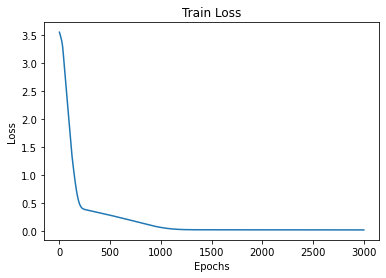

In [16]:
plt.figure()
plt.plot(train_loss1)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [17]:
test_result = test(net)

Input:  tensor([6.9000, 3.2000, 5.7000], dtype=torch.float64)
Target:  tensor([2.3000], dtype=torch.float64)
Outputs:  tensor([1.9714], dtype=torch.float64)
Input:  tensor([5.6000, 2.8000, 4.9000], dtype=torch.float64)
Target:  tensor([2.], dtype=torch.float64)
Outputs:  tensor([1.6719], dtype=torch.float64)
Input:  tensor([7.7000, 2.8000, 6.7000], dtype=torch.float64)
Target:  tensor([2.], dtype=torch.float64)
Outputs:  tensor([2.3222], dtype=torch.float64)
Input:  tensor([6.3000, 2.7000, 4.9000], dtype=torch.float64)
Target:  tensor([1.8000], dtype=torch.float64)
Outputs:  tensor([1.6138], dtype=torch.float64)
Input:  tensor([6.7000, 3.3000, 5.7000], dtype=torch.float64)
Target:  tensor([2.1000], dtype=torch.float64)
Outputs:  tensor([1.9945], dtype=torch.float64)
Input:  tensor([7.2000, 3.2000, 6.0000], dtype=torch.float64)
Target:  tensor([1.8000], dtype=torch.float64)
Outputs:  tensor([2.0833], dtype=torch.float64)
Input:  tensor([6.2000, 2.8000, 4.8000], dtype=torch.float64)
Targ

In [2]:
torch.save(net, './iris_autoencoder')

NameError: name 'net' is not defined

In [20]:
load_model = torch.load('iris_autoencoder')
load_model

Autoencoder(
  (enc1): Linear(in_features=3, out_features=2, bias=True)
  (enc2): Linear(in_features=2, out_features=1, bias=True)
  (dec1): Linear(in_features=1, out_features=1, bias=True)
)

In [21]:
test_result = test(load_model)

Input:  tensor([6.9000, 3.2000, 5.7000], dtype=torch.float64)
Target:  tensor([2.3000], dtype=torch.float64)
Outputs:  tensor([1.9714], dtype=torch.float64)
Input:  tensor([5.6000, 2.8000, 4.9000], dtype=torch.float64)
Target:  tensor([2.], dtype=torch.float64)
Outputs:  tensor([1.6719], dtype=torch.float64)
Input:  tensor([7.7000, 2.8000, 6.7000], dtype=torch.float64)
Target:  tensor([2.], dtype=torch.float64)
Outputs:  tensor([2.3222], dtype=torch.float64)
Input:  tensor([6.3000, 2.7000, 4.9000], dtype=torch.float64)
Target:  tensor([1.8000], dtype=torch.float64)
Outputs:  tensor([1.6138], dtype=torch.float64)
Input:  tensor([6.7000, 3.3000, 5.7000], dtype=torch.float64)
Target:  tensor([2.1000], dtype=torch.float64)
Outputs:  tensor([1.9945], dtype=torch.float64)
Input:  tensor([7.2000, 3.2000, 6.0000], dtype=torch.float64)
Target:  tensor([1.8000], dtype=torch.float64)
Outputs:  tensor([2.0833], dtype=torch.float64)
Input:  tensor([6.2000, 2.8000, 4.8000], dtype=torch.float64)
Targ

In [22]:
iris = load_iris()
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [23]:
extracted_data = iris['data']
extracted_data.shape

(150, 4)

In [24]:
features = extracted_data[:, :-1]       # Extract the first three columns

input_features = torch.from_numpy(features)
input_features.view(1, 150, 3)

tensor([[[5.1000, 3.5000, 1.4000],
         [4.9000, 3.0000, 1.4000],
         [4.7000, 3.2000, 1.3000],
         [4.6000, 3.1000, 1.5000],
         [5.0000, 3.6000, 1.4000],
         [5.4000, 3.9000, 1.7000],
         [4.6000, 3.4000, 1.4000],
         [5.0000, 3.4000, 1.5000],
         [4.4000, 2.9000, 1.4000],
         [4.9000, 3.1000, 1.5000],
         [5.4000, 3.7000, 1.5000],
         [4.8000, 3.4000, 1.6000],
         [4.8000, 3.0000, 1.4000],
         [4.3000, 3.0000, 1.1000],
         [5.8000, 4.0000, 1.2000],
         [5.7000, 4.4000, 1.5000],
         [5.4000, 3.9000, 1.3000],
         [5.1000, 3.5000, 1.4000],
         [5.7000, 3.8000, 1.7000],
         [5.1000, 3.8000, 1.5000],
         [5.4000, 3.4000, 1.7000],
         [5.1000, 3.7000, 1.5000],
         [4.6000, 3.6000, 1.0000],
         [5.1000, 3.3000, 1.7000],
         [4.8000, 3.4000, 1.9000],
         [5.0000, 3.0000, 1.6000],
         [5.0000, 3.4000, 1.6000],
         [5.2000, 3.5000, 1.5000],
         [5.2000, 3.

In [25]:
new_column = load_model(input_features.double())

In [26]:
new_column

tensor([[0.2194],
        [0.1882],
        [0.1760],
        [0.2626],
        [0.2355],
        [0.3675],
        [0.2455],
        [0.2617],
        [0.2143],
        [0.2416],
        [0.2608],
        [0.3201],
        [0.1952],
        [0.0974],
        [0.1269],
        [0.3031],
        [0.1903],
        [0.2194],
        [0.3374],
        [0.2909],
        [0.3223],
        [0.2819],
        [0.0863],
        [0.3343],
        [0.4530],
        [0.2698],
        [0.3060],
        [0.2567],
        [0.2034],
        [0.3090],
        [0.2929],
        [0.2336],
        [0.3110],
        [0.2547],
        [0.2416],
        [0.1107],
        [0.1471],
        [0.2425],
        [0.1790],
        [0.2547],
        [0.1821],
        [0.1086],
        [0.1971],
        [0.3151],
        [0.4682],
        [0.1952],
        [0.3352],
        [0.2274],
        [0.2678],
        [0.2084],
        [1.5213],
        [1.4747],
        [1.6079],
        [1.2349],
        [1.4758],
        [1

In [27]:
new_dataset = np.concatenate((features, new_column.detach().numpy()), axis=1)
np.set_printoptions(precision=2, suppress=True)
new_dataset

array([[5.1 , 3.5 , 1.4 , 0.22],
       [4.9 , 3.  , 1.4 , 0.19],
       [4.7 , 3.2 , 1.3 , 0.18],
       [4.6 , 3.1 , 1.5 , 0.26],
       [5.  , 3.6 , 1.4 , 0.24],
       [5.4 , 3.9 , 1.7 , 0.37],
       [4.6 , 3.4 , 1.4 , 0.25],
       [5.  , 3.4 , 1.5 , 0.26],
       [4.4 , 2.9 , 1.4 , 0.21],
       [4.9 , 3.1 , 1.5 , 0.24],
       [5.4 , 3.7 , 1.5 , 0.26],
       [4.8 , 3.4 , 1.6 , 0.32],
       [4.8 , 3.  , 1.4 , 0.2 ],
       [4.3 , 3.  , 1.1 , 0.1 ],
       [5.8 , 4.  , 1.2 , 0.13],
       [5.7 , 4.4 , 1.5 , 0.3 ],
       [5.4 , 3.9 , 1.3 , 0.19],
       [5.1 , 3.5 , 1.4 , 0.22],
       [5.7 , 3.8 , 1.7 , 0.34],
       [5.1 , 3.8 , 1.5 , 0.29],
       [5.4 , 3.4 , 1.7 , 0.32],
       [5.1 , 3.7 , 1.5 , 0.28],
       [4.6 , 3.6 , 1.  , 0.09],
       [5.1 , 3.3 , 1.7 , 0.33],
       [4.8 , 3.4 , 1.9 , 0.45],
       [5.  , 3.  , 1.6 , 0.27],
       [5.  , 3.4 , 1.6 , 0.31],
       [5.2 , 3.5 , 1.5 , 0.26],
       [5.2 , 3.4 , 1.4 , 0.2 ],
       [4.7 , 3.2 , 1.6 , 0.31],
       [4.

In [28]:
np.savetxt('first_iris.csv', new_dataset)